# Basics of Spin Systems

_This notebook explains how to use QuSpin to study some properties of quantum spin systems._

The complete **documentation** for `quspin`, including ***example codes***, is available online at [https://quspin.github.io/QuSpin/index.html](https://quspin.github.io/QuSpin/index.html).

Here, we'll start simple and then slowly increase the level of complexity of the systems we discuss. 

## Spin-$1/2$ systems or Two-level system or Qubit

Hilbert space: $\mathbb{C}^2$. Quantum states can be represented on the Bloch sphere, and can be parametrized as:

$$
|\psi_+\rangle = e^{i\alpha}\begin{pmatrix} \cos(\theta/2) \\ e^{i\varphi} \sin(\theta/2) \end{pmatrix}, \qquad
|\psi_-\rangle = e^{i\alpha'}\begin{pmatrix} \sin(\theta/2) \\ -e^{i\varphi} \cos(\theta/2) \end{pmatrix}, \qquad \langle\psi_\pm|\vec\sigma |\psi_\pm\rangle = \pm\frac{\vec h}{|\vec h|} 
= \pm \begin{pmatrix} \sin\theta\cos\varphi \\ \sin\theta\sin\varphi \\ \cos\theta \end{pmatrix} 
$$

The most general Hamiltonian: 

$$H = h_x\sigma^x + h_y\sigma^y + h_z\sigma^z = \vec{h}\cdot\vec{\sigma}$$

has eigenenergies and eigenstates given by $H|{\psi_\pm}\rangle = E_\pm |{\psi_\pm}\rangle$ with $E_\pm = \pm|\vec{h}|$.

How do we code this in `quspin`?


In [15]:
import sys,os

quspin_path = os.path.join(os.path.expanduser('~'),"./quspin/QuSpin_dev")
sys.path.insert(0,quspin_path)

os.environ['KMP_DUPLICATE_LIB_OK']='True' # uncomment this line if omp error occurs on OSX for python 3
os.environ['OMP_NUM_THREADS']='4' # set number of OpenMP threads to run in parallel
os.environ['MKL_NUM_THREADS']='1' # set number of MKL threads to run in parallel

from matplotlib import pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica",
    "font.size": "16",
})
%matplotlib inline

import numpy as np 
np.set_printoptions(suppress=True,precision=3)

### Defining `basis` objects in `quspin`

To construct a basis for the Hilbert space in `quspin`, we call the basis constructor `spin_basis_1d`. This works as follows

In [16]:
from quspin.basis import spin_basis_1d

basis_1 = spin_basis_1d(L=1) # single spin-1/2 particle / qubit / two-level system
print(basis_1)

reference states: 
array index   /   Fock state   /   integer repr. 
 0.  |1>  1 
 1.  |0>  0 


Notice that this is the Pauli-$z$ basis. This is the default basis in which `quspin` works; you can then transform to any other basis by applying a unitary operation. The $z$-basis is often called the _computational basis_. 

Quantum states are represented by `numpy` arrays. To be able to define the states we want, notice that:

* the array index in the basis above defines the array entry index for a given basis state. This means that if you expand any state as $|\psi\rangle = a|\uparrow\rangle + b|\downarrow\rangle$, you can read off the expansion coefficients $a,b$ from the vector array.
  
* the second column shows the Fock states representation of the state; here we use the convention $|\uparrow\rangle = |1\rangle$, $|\downarrow\rangle=|0\rangle$.

* the last column is the integer representation of the state; we'll see what this means below.

Now, let us construct a few states to see how that works in practice:

In [17]:
# define state |0> = |down>
psi_down = np.array([0.0,1.0])
print('|down>:', psi_down)

# define state |1> = |up>
psi_up = np.array([1.0,0.0])
print('|up>:',psi_up)

# define a superposition state: (|0>+|1>)/sqrt(2)
psi_plus = np.array([1.0,1.0])/np.sqrt(2)
print('1/sqrt(2)(|0>+|1>):', psi_plus)

|down>: [0. 1.]
|up>: [1. 0.]
1/sqrt(2)(|0>+|1>): [0.707 0.707]


### Computing state overlaps

... is straightforward

In [18]:
# compute overlap <up|+> 
overlap = psi_up.conj() @ psi_plus
print('<up|psi>:', overlap)
# compute overlap squared |<up|+>|^2 
print('|<up|psi>|^2:', np.abs(overlap)**2 )

<up|psi>: 0.7071067811865475
|<up|psi>|^2: 0.4999999999999999


### Constructing single-qubit Hamiltonians in `quspin`

Now that we've defined the basis (and implicitly our Hilbert space), we can move to the description of quantum systems. Hamiltonians and general operators are defined using the `hamiltonian` constructor of QuSpin's `quantum_operators` module. 

As we saw above, the most general Hamiltonian for a single spin takes the form $H = h_x\sigma^x + h_y\sigma^y + h_z\sigma^z$. To implement it, we need to define the coupling strengths $h_\alpha$ and the corresponding Pauli matrices. 

Technically, in `quspin` we need to give a label to the spin degree of freedom; we call it spin number 0.  The procedure then goes like this: 

In [19]:
from quspin.operators import hamiltonian

# define couplings strengths 
hx, hy, hz = 1.0, 1.0, 1.0 

# associate each coupling to the spin labeled 0
hx_list = [[hx,0],] # coupling: hx multiplies spin labeled 0
hy_list = [[hy,0],] # coupling: hy multiplies spin labeled 0 
hz_list = [[hz,0],] # coupling: hz multiplies spin labeled 0

# associate a Pauli matrix to each coupling list
static_terms = [['x',hx_list], # assign coupling list hx_list to pauli operator sigma^x
    		    ['y',hy_list], # assign coupling list hy_list to pauli operator sigma^y
    		    ['z',hz_list], # assign coupling list hz_list to pauli operator sigma^z
    		   ]
dynamic_terms = [] # ignore this for the time being
# construct Hamiltonian in the basis defined above
H_1 = hamiltonian(static_terms, dynamic_terms, basis=basis_1,)

Hermiticity check passed!
Symmetry checks passed!


A few remarks:
* if the many lists of lists look cumbersome and unnecessary to you, just wait to generalize this to more complex spin chains and you'll see where this notation comes from.
* note the messages on hermiticity and symmetry checks; `quspin` performs checks under the hood to make sure you don't mess things up by mistake. You can disable these by passing the flags `check_herm=False`, `check_symm=False`, etc. (see [online documentation](https://quspin.github.io/QuSpin/generated/quspin.operators.hamiltonian.html#quspin.operators.hamiltonian))

The Hamiltonian is a special `hamiltonian` object which contains a static and a dynamic matrix (empty, ignore for now). The static part is a sparse matrix whose entries are displayed below:

In [20]:
print(H_1)

static mat: 
  (0, 0)	(1+0j)
  (0, 1)	(1-1j)
  (1, 0)	(1+1j)
  (1, 1)	(-1+0j)


dynamic:



Once constructed, you can also cast the Hamiltonian into a `numpy` or `scipy` array of different kinds, and manipulate it however you like.

In [21]:
print('cast as a dense array:')
print(H_1.toarray())
print('cast as a scipy csr array:')
print(H_1.tocsr()) 
print('cast as a scipy csc array:')
print(H_1.tocsc()) 

cast as a dense array:
[[ 1.+0.j  1.-1.j]
 [ 1.+1.j -1.+0.j]]
cast as a scipy csr array:
  (0, 0)	(1+0j)
  (0, 1)	(1-1j)
  (1, 0)	(1+1j)
  (1, 1)	(-1+0j)
cast as a scipy csc array:
  (0, 0)	(1+0j)
  (1, 0)	(1+1j)
  (0, 1)	(1-1j)
  (1, 1)	(-1+0j)


### Applying `quspin` operators to states

... is as easy as you can think, and goes using the `dot` method:

In [22]:
phi = H_1.dot(psi_plus) # |phi> = H|+>
print('psi:', psi_plus)
print('phi:', phi)

psi: [0.707 0.707]
phi: [1.414-0.707j 0.   +0.707j]


### Computing expectation values of observables 

... is also easy using the `expt_value` method of the `hamiltonian` class:

In [23]:
# compute expectation value <down|H|down>
expt_H_1_psi = H_1.expt_value(psi_down)
print('<down|H|down>:', expt_H_1_psi) 

<down|H|down>: (-1+0j)


Note that the imaginary part is zero, as it should be; if this annoys you you can always case the output to a real number using `.real`. We decided to keep it more general, since: 
1. it's a good check you're doing things right, and 
2. the `expt_value` method can then be used for non-hermitian operators, such as $\sigma^\pm$. 

## Two coupled Spin-$1/2$ particles

Let us now consider two spin particles, labeled by the index $j=0,1$. Each particle has its own set of Pauli matrices $\sigma^\alpha_j$, and $\alpha=x,y,z,+,-$.

Since we're now dealing with the Hilbert space $\mathbb{C}^4$, we'd need to construct a new computational basis:

In [24]:
### two coupled spins / qubits
basis_2 = spin_basis_1d(L=2)
print(basis_2)

reference states: 
array index   /   Fock state   /   integer repr. 
 0.  |1 1>  3 
 1.  |1 0>  2 
 2.  |0 1>  1 
 3.  |0 0>  0 


As before, the first column shows the index in the array, and can be used to read off state components/amplitudes, and operator matrix elements.

The second column now shows the four two-spin basis states: $\ket{11}, \ket{10}, \ket{01}, \ket{00}$.

The last column represents the integer representation of each basis state. As you can see, states in the computational basis are in one-to-one correspondence with bitstrings (i.e., strings consisting of 1's and 0's). One can then associate to each bitstring an integer number, shown in the last column. That's the integer representation of the state. Internally, quspin doesn't store large vectors; instead, it manipulates in a smart way the bitstrings (e.g., when applying operators to the states, etc.).  

To find the bitstring corresponding to an integer, you can use built-in python functions:

In [25]:
print('map the integer 1 to bitstring of length 2:','{0:02b}'.format(1) ) # map integer repr. to quant state

map the integer 1 to bitstring of length 2: 01


Conversely, one can also map a bit string to its integer representation using the `state_to_int` method of the `basis_2`:

In [26]:
print('map quantum state |01> to its integer rep:', basis_2.state_to_int('01'))

map quantum state |01> to its integer rep: 1


Perhaps more useful is the mapping from a given bitstring to the array index; this helps us define states more easily, and especially in large spin systems. 

In [27]:
print('array index of a basis state |01>:', basis_2.index('01')) # find array index of a given basis state

array index of a basis state |01>: 2


Now let's use these functions to create some interesting states:

In [28]:
# define state |01> 
psi_01 = np.zeros(basis_2.Ns) # initialize an empty array
psi_01[basis_2.index('01')]=1.0 # set index corresponding to state '01' to value 1.0
print('|01>:', psi_01)

# define state the Bell state 1/sqrt(2)(|01> + |10>) 
psi_Bell = np.zeros(basis_2.Ns) # empty array
psi_Bell[basis_2.index('01')]=1.0 # set index corresponding to state '01' to value 1.0
psi_Bell[basis_2.index('10')]=1.0 # set index corresponding to state '10' to value 1.0
psi_Bell/=np.linalg.norm(psi_Bell) # normalize state
print('Bell state 1/sqrt(2)(|01> + |10>) :', psi_Bell)

|01>: [0. 0. 1. 0.]
Bell state 1/sqrt(2)(|01> + |10>) : [0.    0.707 0.707 0.   ]


### Constructing two-spin Hamiltonians in `quspin`

Consider the two-spin Heisenberg model, defined by the Hamiltonian

$$H = \frac{J_{xy}}{2}\left(\sigma^+_{0}\sigma^-_1 + \sigma^-_{0}\sigma^+_1\right) + J_{zz}\sigma^z_{0}\sigma^z_1 $$


In [29]:
# define couplings
Jxy, Jzz = 1.0,1.0

# define site-coupling lists
Jxy_list = [[0.5*Jxy,0,1],] # coupling strength Jxy/2 couples spin 0 and spin 1
Jzz_list = [[Jzz,0,1],] # coupling strength Jzz couples spin 0 and spin 1

# associate the Pauli matrix terms to each coupling list
H_terms = [['+-',Jxy_list], 
		   ['-+',Jxy_list],
		   ['zz',Jzz_list],
		  ]
# create Hamiltonian
H_Heis = hamiltonian(H_terms,[], basis=basis_2)
#
# print Hamiltonian matrix
print(H_Heis.toarray())

Hermiticity check passed!
Symmetry checks passed!
[[ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j -1.+0.j  2.+0.j  0.+0.j]
 [ 0.+0.j  2.+0.j -1.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j  1.+0.j]]


### Computing eigenstates and eigenenergies

To diagonalize the Hamiltonian, we use the `eigh()` method of the `hamiltonian` constructor, which returns a tuple `(E,V)` containign the ordered e'energies `E` and the corresponding eigenstates in the _columns_ of `V`:

In [30]:
# diagonalize Hamiltonian
E, V = H_Heis.eigh()
print(E) # ordered e'energies
print(V) # corresponding e'states in columns
# read off GS and its energy 
E_GS, psi_GS = E[0], V[:,0]

[-3.  1.  1.  1.]
[[ 0.   +0.j  1.   +0.j  0.   +0.j  0.   +0.j]
 [ 0.707+0.j  0.   +0.j  0.707-0.j  0.   +0.j]
 [-0.707-0.j  0.   +0.j  0.707+0.j  0.   +0.j]
 [ 0.   +0.j  0.   +0.j  0.   +0.j  1.   +0.j]]


### Reduced density matrix and quantum entanglement

Quantum entanglement is a measure for the quantum correlation between the qubits. It is seen as a fundamentally quantum resource, and harnessing it is the core of many ongoing quantum technology efforts. 

Recall that to quantify the entanglement between the two qubits, we first need to trace out one of them and obtain the corresponding reduced density matrix $\rho_1$:

$$\rho_1 = \text{tr}_2 \rho_{12},\qquad \rho_{12} = |\psi\rangle\langle\psi|,$$

where the two-qubit system is in the pure state $|\psi\rangle\in\mathbb{C}^4$, and $\rho_{12}$ is the corresponding density matrix. The subscript on the trace operation, $\text{tr}_2$, indicates we're tracing only over the Hilbert space of qubit 2. Alternatively, one can trace out qubit 2, and compute the reduced density matrix for qubit 2, $\rho_{2}$. 

Entanglement between the two qubits in a _pure_ state can then be quantified by computing the von Neumann entropy of the reduced density matrix:

$$ S_\text{ent}^\text{vN} = -\text{tr} \rho_1 \log\rho_1 = -\text{tr} \rho_2 \log\rho_2.$$

However, this is only one measure for entanglement and there are more. A commonly used generalization of the von Neumann entropy is given by the so-called Renyi entropies:

$$ S_\text{ent}^\alpha = \frac{1}{1-\alpha}\log \text{tr} \left( \rho_1^\alpha \right). $$

You can convince yourself that $\lim_{\alpha\to 1} S_\text{ent}^\alpha = S_\text{ent}^\text{vN}$, and hence the von Neumann entropy arises as a special case. All Renyi entropies capture quantum correlation in the same way as the vN entropy: in particular, they vanish for pure states and are maximal for maximally-entangled states. However, as you can see from the above definition, they are computationally lighter to compute since the nonlinear $\log$-operation is only carried out on numbers (as opposed to matrices).  Particularly useful is the Reniy-2 (i.e., $\alpha=2$) entropy, which has even be measured in experiments. 

`quspin` allows us to easily compute Renyi entropies and reduced density matrices. To do this, we use the `ent_entropy()` method of the `basis` constructor, by inputting the pure $2$-qubit state (here `psi_GS`), and defining the subsystem to compute the reduced density matrix of (here `sub_sys_A=[0,]`):

In [31]:
entropy = basis_2.ent_entropy(psi_GS, sub_sys_A=[0,],)
print(entropy)

{'Sent_A': array(0.693)}


As you see, this function returns a dictionary which contains the vN entropy of the reduced rensity matrix over `sub_sys_A`.

We can also obtain the corresponding reduced density matrix:

In [32]:
entropy = basis_2.ent_entropy(psi_GS, sub_sys_A=[0,],return_rdm='A', alpha=1)
print(entropy)

{'Sent_A': array(0.693), 'rdm_A': array([[0.5+0.j, 0. +0.j],
       [0. +0.j, 0.5+0.j]])}


To read off the objects, we do

In [33]:
Sent_A = entropy['Sent_A']
rdm_A = entropy['rdm_A']
print('vN entropy:', Sent_A)
print('reduced density matrix of subsystem A:,\n', rdm_A)

vN entropy: 0.6931471805599452
reduced density matrix of subsystem A:,
 [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]


Moreover, by specifying the Renyi `alpha` parameter, we can also compute any of the Renyi entropies.

Finally, note that by default `ent_entropy` computes the entropy per spin; you can toggle this option by using the flag `density=False`. For more information about this function, check out the documentation:

[https://quspin.github.io/QuSpin/generated/quspin.basis.spin_basis_1d.html#quspin.basis.spin_basis_1d.ent_entropy](https://quspin.github.io/QuSpin/generated/quspin.basis.spin_basis_1d.html#quspin.basis.spin_basis_1d.ent_entropy)

### Using symmetries in `quspin`

A quantum system is said to have a symmetry $S$ if its Hamiltonian $H$ commutes with the symmetry operator: $[H,S]=0$. Then one can simultaneously diagonalize $S$ and $H$: this means that each eigenstate of $H$ is can be chosen to also be an eigenstate of $S$; in turns, this implies that one can label the eigenstates $|{n,s}\rangle$ of the Hamiltonian $H$, $H|{n}\rangle = E_{n}|{n}\rangle$, by the eigenvalues of the symmetry operator $S$: $S|{s}\rangle = s|{s}\rangle$. In other words,

$$ H|{n,s}\rangle = E_{n,s}|{n,s}\rangle. $$

More generally, one can decompose the Hilbert space into subspaces, one for each eigenvalue of $S$ (these subspaces are called irreducible representations of the symmetry group). The existence of a symmetry is equivalent to saying that states living in subspaces corresponding to different $s$-values, are not coupled by the Hamiltonian $H$; or, in other words, the Hamiltonian matrix is block diagonal. You have already seen this phenomenon in atomic physics when studying the hydrogen atom and discussing the corresponding selection rules: 

$$ H = \begin{pmatrix} \ddots & \vdots & \vdots &  \vdots & \\ \dots &  H_{s-1} & 0 & 0 & \dots \\ \dots & 0 & H_{s} & 0 & \dots\\ \dots & 0 & 0 & H_{s+1} & \dots \\ 
 & \vdots & \vdots & \vdots & \ddots  \end{pmatrix} $$

Let's take a look at a concrete example.

#### Spin exchange symmetry

The Heisenberg Hamiltonian

$$H = \frac{J_{xy}}{2}\left(\sigma^+_{0}\sigma^-_1 + \sigma^-_{0}\sigma^+_1\right) + J_{zz}\sigma^z_{0}\sigma^z_1 $$

remains unchanged if we swap the two spins, i.e., under the spin exchange transformation 

$$S: \vec \sigma_0\leftrightarrow \vec \sigma_1.$$

If you repeat the spin swap operation, you come back to where you started; hence, the spin exchange symmetry can be described by the $\mathbb{Z}_2$ group. Moreover, it follows that $S^2 = \mathbb{1}$; hence, the two eigenvalues of $S$ are $s=\pm 1$. Here $s=+1$ corresponds to a symmetric wavefunction under spin exchange, whereas $s=-1$ - to an antisymmetric wavefunction.  

Therefore, the eigenvectors of $S$ are given by:

$$ s=-1:\qquad |{s=-1}\rangle = \frac{1}{\sqrt 2} \left( \ket{10} - \ket{01} \right) $$

$$ s=+1:\qquad |{s=+1,m=-1}\rangle = \ket{00}, \qquad 
                              |{s=+1,m=0}\rangle = \frac{1}{\sqrt 2} \left( |{10}\rangle + |{01}\rangle \right), \qquad
                              |{s=+1,m=+1}\rangle = |{11}\rangle.
$$

These are the familiar single and triplet manifolds that you get when adding two spin-$1/2$ particles. 

The above analysis tells us that the Hilbert space $\mathcal{H}=\mathbb{C}^4$ can be split into two orthogonal subspaces (one for each eigenvalue, $s=\pm 1$), of dimensions $1$ and $3$, respectively: $\mathcal{H} = \mathbb{C}\oplus \mathbb{C}^3$. Therefore, we expect the Hamiltonian to look like


$$ H = \begin{pmatrix} H_{-1}^{1\times 1} & 0 \\ 0 & H_{+1}^{3\times 3}  \end{pmatrix} $$

Note that this structure emerges in the eigenbasis of $S$; therefore, the matrix elements will in general be different from those in the original basis. 

This analysis can easily become more cumbersome if you consider more complex symmetries, or take into account more spins; this is where `quspin` comes to help. It allows us to construct the Hamiltonian matrix in a fixed symmetry block (or sector). This can save memory and allows us to reach larger system sizes in our classical simulations. 

To implement the spin exchange symmetry, all we need to do is pass the flag `pblock=1` to the `basis` constructor; the value defines the symmetry sector:

In [34]:
basis_symm = spin_basis_1d(L=2, pblock=1)
print(basis_symm)

reference states: 
array index   /   Fock state   /   integer repr. 
 0.  |1 1>  3 
 1.  |1 0>  2 
 2.  |0 0>  0 
The states printed do NOT correspond to the physical states: see review arXiv:1101.3281 for more details about reference states for symmetry-reduced blocks.



We notice a few things:
* the number of states reduced from 4 to 3 (as expected);
* the array index is still a consecutive integer but the integer representation is no longer;
* the code now displays a warning: `the states printed do NOT correspond to the physical states`.

Let's focus on the last point: indeed, the states displayed stand for the three e'states in the triplet sector (see above). While $|{11}\rangle$ and $|{00}\rangle$ coincide with the original basis states, $|{10}\rangle \; \widehat{=}\;  \left( |{10}\rangle + |{01}\rangle \right)/\sqrt{2} $ stands for the entire superposition. Thus, you have to be extra cautious when defining states and reading off matrix elements if symmetries are turned on.

Constructing the Hamiltonian is now simple; we just need to pass the new basis object. As expected, it's a 3x3 matrix. Moreover, the three eigenvalues coincide exactly with three of the 4 eigenvalues we computed above. 

In [35]:
# create Hamiltonian
H_Heis_symm = hamiltonian(H_terms,[], basis=basis_symm)
#
# print Hamiltonian matrix
print(H_Heis_symm.toarray())
# print e'values
E = H_Heis_symm.eigvalsh()
print("e'values in the p=+1 sector:", E)

Hermiticity check passed!
Symmetry checks passed!
[[1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j]]
e'values in the p=+1 sector: [1. 1. 1.]


`quspin` also allows you to use other symmetries: examples include:
* reflection/parity:  $\vec\sigma_j \to \vec\sigma_{L-j-1}$
* spin inversion: $|{1}\rangle_j \leftrightarrow |{0}\rangle_j$
* translation: $\vec\sigma_j \to\vec\sigma_{j+1}$
* various combinations of these
* custom symmetries, see `spin_basis_general` and `user_basis` classes in the online documentation. 
  

### Spin chains

Let's scale up the number of spins in our system; our first goal is to employ `quspin` and construct the Hamiltonian matrix for a few commonly used many-body spin models: 
* quantum Ising model (IM):
 
    $$ H_\text{Ising} = \sum_{j} J\sigma^z_{j+1}\sigma^z_j + h_x\sigma^x_j + h_z\sigma^z_j $$

* Heisenberg model:
      $$ H_\text{Heis} = \sum_{j} \frac{J_{xy}}{2}\left(\sigma^+_{j+1}\sigma^-_{j} + \text{h.c.}\right) + J_{zz}\sigma^z_{j+1}\sigma^z_j $$

Below, we show how to do this for the Ising model; you can then try doing the same for the Heisenberg chain. 

In [36]:
# system size / number of spins
L = 10 
# compute basis
basis_ising = spin_basis_1d(L=L,)
# define site-coupling lists
Jzz_list = [[Jzz,j,j+1] for j in range(L-1)] # L-1 bonds
hz_list = [[hz,j] for j in range(L)] # L sites
hx_list = [[hx,j] for j in range(L)] # L sites
# define Hamiltonian terms
H_terms = [['zz',Jzz_list], 
		   ['x',hx_list],
		   ['z',hz_list],
		  ]
H_Ising = hamiltonian(H_terms,[], basis=basis_ising)
# cast to array
print('\nIsing Hamiltonian matrix:\n', H_Ising.toarray())
print('\n')

# compute eigenenergies and eigenstates
E, V = H_Ising.eigh()
# ground state
psi_GS = V[:,0]
# first-excited state
psi_ex_1 = V[:,1]

Hermiticity check passed!
Symmetry checks passed!

Ising Hamiltonian matrix:
 [[19.+0.j  1.+0.j  1.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 1.+0.j 15.+0.j  0.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 [ 1.+0.j  0.+0.j 13.+0.j ...  0.+0.j  0.+0.j  0.+0.j]
 ...
 [ 0.+0.j  0.+0.j  0.+0.j ... -3.+0.j  0.+0.j  1.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  0.+0.j -1.+0.j  1.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j ...  1.+0.j  1.+0.j -1.+0.j]]




We can now look at the density of states (DOS): 

$$ \text{DOS}(E) = \sum_{n} \delta(E-E_n) $$

where $E_n$ is an e'energy ($E_n\leq E_{n+1}$), and the index $n$ runs over the entire spectrum.

The DOS can be approximately calculated by computing the histogram over the _previously ordered_ spectrum; for ergodic spin chains, it resembles a Gaussian:

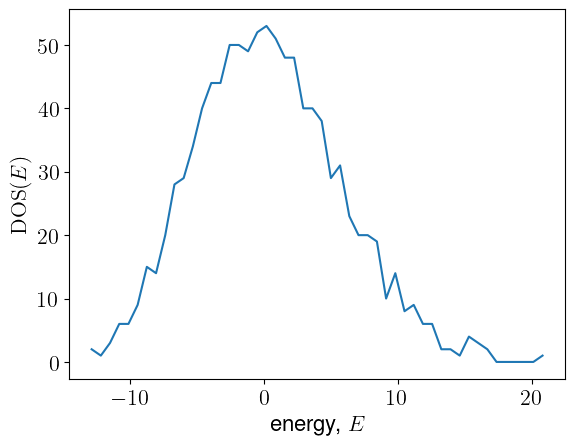

In [37]:
# compute histogram
DOS, energy =  np.histogram(E, bins=50) # number of bins can be adjusted
# plot histogram
plt.plot(energy[1:], DOS) # energy array has one vertex more than the DOS array
plt.xlabel('energy, $E$')
plt.ylabel('$\mathrm{DOS}(E)$')
plt.show()

The concepts of entanglement and Renyi entropies also generalize to many-body systems. When computing the entanglement entropy, we now have to specify the lattice sites contained in the reduced subsystem, i.e., `sub_sys_A`. 

Typically, this is taken to be the left half of the chain, but subsystem A need not be a contiguous region, e.g., it can be defined as a specific sublattice.  

In [38]:
# half-chain entanglement entropy of ground state
vN_entropy = basis_ising.ent_entropy(psi_GS, sub_sys_A=[j for j in range(L//2)], alpha=1, density=False)
# half-chain Reniy-2 entropy of ground state
Renyi_entropy = basis_ising.ent_entropy(psi_GS, sub_sys_A=[j for j in range(L//2)], alpha=2, density=False)
#
print('von Neumann entropy:', vN_entropy['Sent_A'])
print('Renyi-2 entropy:', Renyi_entropy['Sent_A'])

von Neumann entropy: 0.22695487032132466
Renyi-2 entropy: 0.1188793781394525


### Time evolution

Let us now turn to the time evolution of quantum many-body spin systems. In general, we can consider two types of dynamics (depending on the properties of the Hamiltonian):
* ***quenches:*** given a quantum state $|{\psi_0}\rangle$ and a time-*independent* Hamiltonian $H$, in a quench we expose the state to a sudden turn on of the Hamiltonian and track its time evolution. The evolution of the state is then described by the solution to Schroedinger's equation:
  $$ |{\psi(t)}\rangle = \exp\left(-i t H\right)|{\psi_0}\rangle $$
* ***drives:*** a driven quantum system is one where the initial state $\ket{\psi_0}$ evolves according to a time-*dependent* Hamiltonian $H(t)$. The time-evolved state can be formally written down with the help of a time-ordered exponential
  $$ |{\psi(t)}\rangle = \mathcal{T}_t \exp\left(-i \int_0^t\mathrm d s H(s) \right)|{\psi_0}\rangle = \lim_{\substack{N\to\infty}} \prod_{n=1}^N \exp\left(-i \frac{t}{N} H\left(n\frac{t}{N}\right) \right)|{\psi_0}\rangle  $$

#### Static Hamiltonians: quenches

Time evolution under static Hamiltonians can be conveniently implemented using `quspin`. To this end, we first divide the time interval $t$ into many small steps of size $\delta t$; the time-evolution operator then takes the form
$$ \exp\left(-i t H\right) = \prod_{n=1}^N \exp\left(-i \delta t H \right) = \prod_{n=1}^N U(\delta t) $$
where $\delta t = {t}/{N}$, and $N$ is _any_ integer.

Suppose now we want to study the quench dynamics of the Schroedinger cat state<a name="footnote-1"></a>[<sup>[1]</sup>](#footnote-1) of $L$ spins,
$$ |{\text{cat}}\rangle = \frac{1}{\sqrt 2}\left( |{00\cdots 0}\rangle + |{11\cdots 1}\rangle \right), $$
under the Ising Hamiltonian:
$$ H_\text{Ising} = \sum_{j} J\sigma^z_{j+1}\sigma^z_j + h_x\sigma^x_j + h_z\sigma^z_j.$$

We want to compute:
1. the time-evolved state;
2. the expectation value of the energy $E(t) = \langle{\psi(t)}| H_\text{Ising}|{\psi(t)}\rangle$;
3. the evolution of the entanglement entropy $S_\text{ent}^\text{vN}(t)$ between the left and right halves of the spin chain.

<sub><a name="footnote-1"></a>[[1]](#footnote-1-1): This state is a superposition of two microscopic quantum states which, e.g., can represent Schroedinger's cat being both dead and alive, whence the name.</sub> 


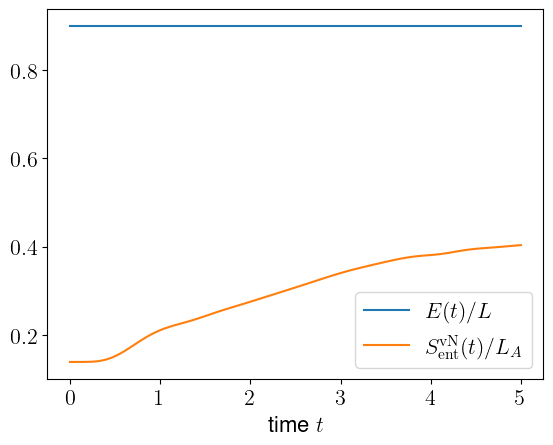

In [39]:
from scipy.sparse.linalg import expm # matrix exponential for sparse generators

# define times vector and timestep
N_timesteps = 101 # number of timesteps
times, dt = np.linspace(0.0,5.0,N_timesteps, retstep=True)

# compute unitary
U_dt = expm(-1j*dt*H_Ising.tocsc()) # cast `hamiltonian' object H as a sparse matrix first

# initial state: cat state (|00...0> + |11...1>)/sqrt(2)
psi_cat = np.zeros(basis_ising.Ns) # empty array of size basis_ising.Ns = 2**L
psi_cat[basis_ising.index('0'*L)]=1.0 # set index corresponding to state '00...0' to value 1.0
psi_cat[basis_ising.index('1'*L)]=1.0 # set index corresponding to state '11...1' to value 1.0
psi_cat/=np.linalg.norm(psi_cat) # normalize state

# pre-allocate memory to store value of observables
psi_cat_t = np.zeros((basis_ising.Ns,N_timesteps), dtype=np.complex128 ) # to-be evolved state
E_t = np.zeros(N_timesteps, dtype=np.float64 ) # to-be energy expectations
Sent_t = np.zeros(N_timesteps, dtype=np.float64 ) # to-be entanglement entropies density

# compute time evolution using a recursive time loop
psi_cat_t[:,0] = psi_cat[:] # set initial state, [:] copies memory view
E_t[0] = H_Ising.expt_value(psi_cat).real # set initial energy value
Sent_t[0] = basis_ising.ent_entropy(psi_cat,)['Sent_A'] # set initial entanglement entropy value
# run time evolution
for j in np.arange(N_timesteps-1):
    # evolve
	psi_cat_t[:,j+1] = U_dt @ psi_cat_t[:,j] # evolve state one step forward
	# measure
	E_t[j+1] = H_Ising.expt_value(psi_cat_t[:,j+1]).real # <psi(t)|H_Ising|psi(t)>
	Sent_t[j+1] = basis_ising.ent_entropy(psi_cat_t[:,j+1])['Sent_A'] # entanglement density of half chain

# plot results
plt.plot(times, E_t/basis_ising.L, label='$E(t)/L$')
plt.plot(times, Sent_t, label='$S_\mathrm{ent}^\mathrm{vN}(t)/L_A$')
plt.xlabel('time $t$')
plt.legend()
plt.show()

Now, let's code a driven system. Once again we start from a cat initial state, but this time we want to evolve it under the time-periodic Ising Hamiltonian

$$ H_\text{Ising}(t) = \sum_j J_{zz} \sigma^z_j \sigma^z_{j+1} + h_x\sigma^x_j + h_z \cos(\omega t) \sigma^z_j = H_0 + f(t) H_1 $$

`quspin` encodes driven Hamiltonian by storing separately the time-independent (static) part $H_0$, the time-dependent (dynamic) part given together by the drive $f(t)$ and the operator $H_1$. 

Coding up such a Hamiltonian proceeds as before, except now we need to define the drive $f(t)$ and pass it to the `dynamic_terms` list:

In [40]:
# construct basis
L = 10 # three spins
basis_ising_t = spin_basis_1d(L=L,)

# define coupling lists
Jzz_list = [[Jzz,j,j+1] for j in range(L-1)] # L-1 bonds
hz_list  = [[hz,j] for j in range(L)] # L sites
hx_list  = [[hx,j] for j in range(L)] # L sites

# define drive function
omega = 4.0 # drive frequency
def drive(t, omega): # first argument must be time, followed by any parameters
	return np.cos(omega*t)
drive_args=(omega,) # tuple containing parameters of drive (all arguments passed, except time t)

# define Hamiltonian
static_terms = [['zz',Jzz_list], ['x',hx_list], ] # as before (see above)
dynamic_terms =[['z',hz_list, drive, drive_args],] # add drive function and its arguments to this list
H_Ising_t = hamiltonian(static_terms,dynamic_terms, basis=basis_ising_t) # note we also pass dynamic_terms

print(H_Ising_t)

Hermiticity check passed!
Symmetry checks passed!
static mat: 
  (0, 0)	(9+0j)
  (0, 1)	(1+0j)
  (0, 2)	(1+0j)
  (0, 4)	(1+0j)
  (0, 8)	(1+0j)
  (0, 16)	(1+0j)
  (0, 32)	(1+0j)
  (0, 64)	(1+0j)
  (0, 128)	(1+0j)
  (0, 256)	(1+0j)
  (0, 512)	(1+0j)
  (1, 0)	(1+0j)
  (1, 1)	(7+0j)
  (1, 3)	(1+0j)
  (1, 5)	(1+0j)
  (1, 9)	(1+0j)
  (1, 17)	(1+0j)
  (1, 33)	(1+0j)
  (1, 65)	(1+0j)
  (1, 129)	(1+0j)
  (1, 257)	(1+0j)
  (1, 513)	(1+0j)
  (2, 0)	(1+0j)
  (2, 2)	(5+0j)
  (2, 3)	(1+0j)
  :	:
  (1021, 1020)	(1+0j)
  (1021, 1021)	(5+0j)
  (1021, 1023)	(1+0j)
  (1022, 510)	(1+0j)
  (1022, 766)	(1+0j)
  (1022, 894)	(1+0j)
  (1022, 958)	(1+0j)
  (1022, 990)	(1+0j)
  (1022, 1006)	(1+0j)
  (1022, 1014)	(1+0j)
  (1022, 1018)	(1+0j)
  (1022, 1020)	(1+0j)
  (1022, 1022)	(7+0j)
  (1022, 1023)	(1+0j)
  (1023, 511)	(1+0j)
  (1023, 767)	(1+0j)
  (1023, 895)	(1+0j)
  (1023, 959)	(1+0j)
  (1023, 991)	(1+0j)
  (1023, 1007)	(1+0j)
  (1023, 1015)	(1+0j)
  (1023, 1019)	(1+0j)
  (1023, 1021)	(1+0j)
  (1023, 1022)	(1

As you can see, this time the Hamiltonian containes both the static operator $H_0$, as well as the dynamics operator $H_1$; note also that the dynamic part also contains the function $f(t)$ which we called `drive`.

The Hamiltonian can be evaluated at any fixed time $t$ as follows:

In [41]:
print(H_Ising_t(time=0.4321).toarray()) # evaluate H(t) at a fixed time t

[[ 7.43 +0.j  1.   +0.j  1.   +0.j ...  0.   +0.j  0.   +0.j  0.   +0.j]
 [ 1.   +0.j  5.744+0.j  0.   +0.j ...  0.   +0.j  0.   +0.j  0.   +0.j]
 [ 1.   +0.j  0.   +0.j  3.744+0.j ...  0.   +0.j  0.   +0.j  0.   +0.j]
 ...
 [ 0.   +0.j  0.   +0.j  0.   +0.j ...  6.256+0.j  0.   +0.j  1.   +0.j]
 [ 0.   +0.j  0.   +0.j  0.   +0.j ...  0.   +0.j  8.256+0.j  1.   +0.j]
 [ 0.   +0.j  0.   +0.j  0.   +0.j ...  1.   +0.j  1.   +0.j 10.57 +0.j]]


We can also compute expectation values of the Hamiltonian at a fixed parametric time $t$, e.g.

$$ E = \langle{\text{cat}} | H_\text{Ising}(t) |{\text{cat}}\rangle, $$

by adding the optional flag `time`; by default `time=0` (see documentation). Note that this is different from the energy of the time-evolved state!

In [42]:
E = H_Ising_t.expt_value(psi_cat,time=0.9876) # compute <cat|H(t)|cat>

Time-evolving the initial cat state now requires us to solve the time-*dependent* Schroedigner equation. This can be done with the help of a numerical integrator (e.g., a Runge-Kutta solver). 

Luckily, in `quspin` you don't have to know any of these details. Indeed, since every Hamiltonian generates a time evolution, `hamiltonian` objects come with an `evolve` method to time-propagate initial state. 

Let's see how this works in practice. We'll use the same definition of the `times` vector and initial cat state `psi_cat` defined above.

In [43]:
# evolving the initial state psi_0, from initial time times[0]
psi_t = H_Ising_t.evolve(psi_cat, times[0], times) # contains solution at all time points in times
print(psi_t.shape)

(1024, 101)


As you can see, the output of the `evolve` function is an array that contains each of the 1024 components of the wavefunction of the time-evolved state, evaluated at the 101 time points specified in `times`. 

We can now also conveniently measure the energy expectation and entanglement evolution in a single step: 

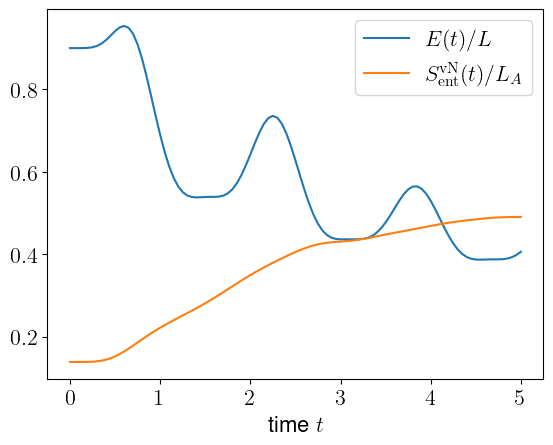

In [44]:
# compute observables
E_t_drive = H_Ising_t.expt_value(psi_t,time=0.0).real # measure <cat(t)|H(0)|cat(t)>
Sent_t_drive = basis_ising_t.ent_entropy(psi_t,)['Sent_A'] # measure Sent (density) in evolved state |psi(t)>

# plot results
plt.plot(times, E_t_drive/basis_ising_t.L, label='$E(t)/L$')
plt.plot(times, Sent_t_drive, label='$S_\mathrm{ent}^\mathrm{vN}(t)/L_A$')
plt.xlabel('time $t$')
plt.legend()
plt.show()